In [74]:
import numpy as np
from numpy.random import RandomState

import pandas as pd

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import distributions as td
from torch.nn import functional as F

## Let's show how a single desirability score can go off the rails, even in a simple situation

### Demographic assumptions

Let's assume we have two types of people - Punks and Mods.  Let's list out core feature of note about the demos:
+ Mods tend to not like punks, and vice versa.  
+ There are many more mods than punks.  
+ Punks are more likely to have a wider diversity of people they'd find attractive in their clique
+ we are currently **NOT considering gender effects**, as we want to highlight the importance of considering groups/cliques/whatever you want to call them

### Ranking assumptions

+ left swipe makes it go down, right swipe makes it go up
+ ...really need some more ideas here, look up ELO or a blog later

+ okay looks like hinge uses the [Gale-Shapley](https://github.com/Vishal-Kancharla/Gale-Shapley-Algorithm#pseudocode-) algorithm, or at least a variant of it.  we will use a small version of it for show

## Generate synthetic dataset

In [217]:
# ---
POP = dict(
    MOD = 0.9,
    PUNK = 0.1,
)

P_REJECT = dict(
    MOD = dict(
        MOD = 0.0,
        PUNK = 0.8,
    ),
    PUNK = dict(
        MOD = 0.95,
        PUNK = 0.0,
    ),
)

SCALE = dict(
    MOD = 1.,
    PUNK = 2.,
)

SEED = None
SMALL = 1e-8

# ---
rng = RandomState(SEED)
# ---


def sigmoid(x: float) -> float:
    return 1. / (1. + np.exp(-x))



def p_right_ingroup(
    swiper_score: float, 
    swipee_score: float, 
    swiper_scale: float) -> float:
    """
    return liklihood of swiping given scores and swiper's 
    tolerance of lower scores (swiper scale).
    does this by adding positive stochastic noise to swipee score, scaled on swiper's tolerance
    
    + NOT returning a swipe - returning a PROB of swipe, which adds a third step of stochasticity
        + can treat as deterministic by simply swiping on whether this score is gt or lt 0.
    """
    to_beat = swipee_score + abs(rng.normal(0., swiper_scale))
    return sigmoid(to_beat - swiper_score)
    

def p_right_outgroup(
    swiper_score: float,
    swipee_score: float,
    swiper_scale: float,
    p_reject_outgroup: float,) -> float:
    """
    out of group will be treated simply as a chance to reject independent of scores.
    if not rejected due to group, will be scored same as if in in-group
    """
    if rng.uniform() < p_reject_outgroup:
        p = 0.
    else:
        p = p_right_ingroup(
            swiper_score = swiper_score,
            swipee_score = swipee_score,
            swiper_scale = swiper_scale,
            )
    return p


def p_right(
    swiper_group: str,
    swipee_group: str,
    
    swiper_score: float,
    swipee_score: float,
    ) -> float:
    
    """
    pass in groups and scores and return liklihood of a right swipe.
    note the stochastic steps:
      + p_reject_outgroup (will be 0. if swiper and swipee groups the same)
      + positive noise added to swipee score (scale of noise dependent on swiper_group)
      + NOT returning a swipe - returning a prob of swipe, which adds a third step of stochasticity
        + can treat as deterministic by simply swiping on whether this score is gt or lt 0.
    """
    
    return p_right_outgroup(
        swiper_score = swiper_score,
        swipee_score = swipee_score,

        swiper_scale = SCALE[swiper_group],
        
        p_reject_outgroup = P_REJECT[swiper_group][swipee_group],
    )

def swipe(
    swiper_group: str,
    swipee_group: str,
    
    swiper_score: float,
    swipee_score: float,) -> bool:
    """return a left (False) or right (True) swipe"""
    p = p_right(
        swiper_group = swiper_group,
        swipee_group = swiper_group,
    
        swiper_score = swiper_score,
        swipee_score = swipee_score,
    )
    
    return rng.rand() < p


## draw population
def sample_population(n: int):
    """
    draw a population and return as a well-organized dataframe w score and group,
    sorted by score
    """
    n_punk = int(n * POP["PUNK"])
    n_mod = n - n_punk
    
    punk_scores = rng.normal(0., 1., size = n_punk).tolist()
    mod_scores = rng.normal(0., 1., size = n_mod).tolist()
    
    pdf = pd.DataFrame([punk_scores, ["PUNK"] * n_punk])
    mdf = pd.DataFrame([mod_scores, ["MOD"] * n_mod])
    
    df = pd.concat([pdf.T, mdf.T])\
            .rename(columns={0: "true_ingroup_score", 1: "true_group"})\
            .sort_values(by="true_ingroup_score", ascending=False,)\
            .reset_index(drop=True)
    
    df["current_score"] = [0.] * len(df)
    
    return df


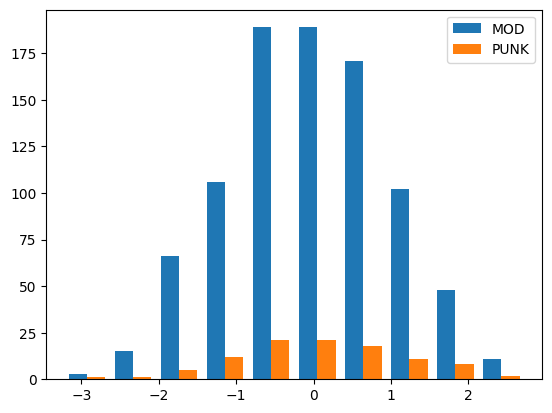

In [218]:
# draw population and ensure we have the demos we expected

N = 1000
df = sample_population(n = N)

groups = df.true_group.unique()

plt.hist(
    [df.loc[df.true_group == x, 'true_ingroup_score'] for x in groups],
    label=groups, 
    bins=N//100)

plt.legend()
plt.show()

In [219]:
# we will do something like the hinge algorithm.  the question is what is stabilizes on recommending

# we'll start by choosing someone with the highest joint liklihood of both swiping yes
swiper = df.iloc[0]

i_candidates = rng.permutation(df.shape[0])[:100]

candidates = df.iloc[i_candidates]

In [220]:
swiper, candidates

(true_ingroup_score    2.719303
 true_group                 MOD
 current_score              0.0
 Name: 0, dtype: object,
     true_ingroup_score true_group  current_score
 627          -0.331321        MOD            0.0
 392            0.26897        MOD            0.0
 684          -0.496088        MOD            0.0
 496          -0.000539        MOD            0.0
 218           0.793987        MOD            0.0
 ..                 ...        ...            ...
 14            2.102111        MOD            0.0
 520          -0.073904        MOD            0.0
 749          -0.686546        MOD            0.0
 217           0.795764       PUNK            0.0
 271           0.632762        MOD            0.0
 
 [100 rows x 3 columns])

In [ ]:
def true_p_match(i_swiper: int, i_swipee: int):
    swiper = df.loc[i_swiper]
    swipee = df.loc[i_swipee]
    
    """
    the TRUE probability of a match bt users given their true in-group
    desirability score, and the true rejection rates of out-groups independent of
    in-group desirability.
    
    also returns a ton of metadata about the two
    """
    p_swiper = p_right(
        swiper_score = swiper.true_ingroup_score,
        swipee_score = swipee.true_ingroup_score,
        swiper_group = swiper.true_group,
        swipee_group = swipee.true_group,
    )
    p_swipee = p_right(
        swiper_score = swipee.true_ingroup_score,
        swipee_score = swiper.true_ingroup_score,
        swiper_group = swipee.true_group,
        swipee_group = swiper.true_group,
    )
    
    p_match = p_swiper * p_swipee
    
    return p_match
    
#     return dict(
#         p_match = p_swiper * p_swipee,
        
#         p_swiper = p_swiper,
#         p_swipee = p_swipee,
        
#         swiper_true_ingroup_score = swiper.true_ingroup_score,
#         swipee_true_ingroup_score = swipee.true_ingroup_score,
        
#         swiper_group = swiper.true_group,
#         swipee_group = swipee.true_group,
        
#         swiper_id = swiper.name,
#         swipee_id = swipee.name,
        
#         current_swiper_score = swiper.current_score,
#         current_swipee_score = swipee.current_score,
#     )

def all_true_match_scores(i_swipee: int):
    def inner(swiper):
        return true_p_match(
            i_swipee = i_swipee,
            i_swiper = swiper.name,
        )
    match_dicts = df.apply(inner, axis=1)
    
    output = pd.DataFrame(match_dicts).rename(columns={0: i_swipee})
    return output

# all scores for a single user
user_0_scores = all_true_match_scores(i_swipee=0)
# all scores bt all users
all_user_scores = df.apply(lambda swipee: all_true_match_scores(swipee.name), axis=1)

In [224]:
match_scores

,p_match,p_swiper,p_swipee,swiper_true_ingroup_score,swipee_true_ingroup_score,swiper_group,swipee_group,swiper_id,swipee_id,current_swiper_score,current_swipee_score
77,0.523254,0.577824,0.905560,2.719303,1.296858,MOD,MOD,0,106,0.0,0.0
45,0.476719,0.506121,0.941908,2.719303,1.067687,MOD,MOD,0,149,0.0,0.0
7,0.457734,0.496000,0.922851,2.719303,1.317695,MOD,MOD,0,100,0.0,0.0
26,0.424603,0.463162,0.916748,2.719303,0.681764,MOD,MOD,0,261,0.0,0.0
24,0.394904,0.465912,0.847594,2.719303,1.838200,MOD,MOD,0,32,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
78,0.000000,0.000000,0.000000,2.719303,0.467996,MOD,PUNK,0,329,0.0,0.0
14,0.000000,0.000000,0.956901,2.719303,-0.313129,MOD,PUNK,0,613,0.0,0.0
29,0.000000,0.000000,0.000000,2.719303,1.671990,MOD,PUNK,0,51,0.0,0.0
79,0.000000,0.000000,0.000000,2.719303,-0.356035,MOD,PUNK,0,632,0.0,0.0


## Inferring desirability score

this is an attempt to infer scores.  it is NOT an attempt to recreate a particular algorithm.  it's meant to capture the following features of a scoring algorithm though, whatever it is:

+ everyone gets a single scalar "desirability" score
+ given two people, the person with the higher score has a higher probability of a right swipe on expectation
+ the higher someone is vs you, the more likely you are to swipe right.
+ the lower someone is vs you, the more likely you are to swipe left.

### current implementation
**NOTE**: read the alg below first, as this will probably be out of date.  just a notepad for my general direction atm

1. everyone swipes given "true" scores and groups
2. rank simply by percentage that swiped you
3. bin ranks
  + **currently here.**  take the percentage of seed swipes, and zscore p(right).  this is your initial score.  now need to figure out how to proceed.  below is just spitballing.
  
general idea from here would be to run the sampling round again, but this time do something smarter with how we sample the next few cards to show (seed round was uniform random)

idea would be to weight likelihood to show you someone based on the p_match function.  however, instead of "true" p_match that is a function group and in-group score, it uses something closer to the current standard algorithm, which only considers a single global inferred score and doesn't consider conditioning on group
  
4. run again, sampling swipes for you normally centered on your current bin
5. move up or down depending how you did in your bin

In [147]:
from typing import List

In [229]:
def swipe(swiper, swipee,) -> bool:
    """return a left (False) or right (True) swipe for two users (rows of df)"""
    p = p_right(
        swiper_group = swiper.true_group,
        swipee_group = swiper.true_group,
    
        swiper_score = swiper.true_ingroup_score,
        swipee_score = swipee.true_ingroup_score,
    )
    
    return rng.rand() < p

In [252]:
def model_infer_p_match(
    swiper_score: float,
    swipee_score: float
) -> float:

    """
    WHAT THE MODEL WILL USE to choose a likilihood of match.
    
    NOT THE TRUE PROB OF A MATCH - for that use fn `true_p_match`.
    
    it will assume it's the joint prob of them both swiping as a function
    of their current inferred score.  note that the alg does not add
    scaling noise for exploration here
    """
    p_right_swiper =  p_right_ingroup(
        swiper_score = swiper_score,
        swipee_score = swipee_score,
        swiper_scale = 0.,
    )
    
    p_right_swipee =  p_right_ingroup(
        swiper_score = swipee_score,
        swipee_score = swiper_score,
        swiper_scale = 0.,
    )
    
    return p_right_swiper * p_right_swipee

In [230]:
# def all_swipe_user(i_swipee: int, i_swipers: List[int]) -> float:
#     """everyone in i_swipers swipes user i_swipee"""
#     swipee = df.iloc[i_swipee]
#     _df = df.iloc(i_swipers)
    
#     def inner(swiper):
#         return swipe(
#             swiper_score = swiper.score,
#             swipee_score = swipee.score,
            
#             swiper_group = swiper.group,
#             swipee_group = swipee.group,
            
#             swiper_id = swiper.name,
#             swipee_id = swipee.name,
#         )
#     swipes = _df.apply(inner, axis=1)
#     return swipes

In [231]:
# from copy import copy

In [288]:
# every user gets some swipes!

# a col is how a particular user swiped on others
# a row is how others swiped on a particular user


def infer_candidate_match_scores(
    i_swipee: int,
#     n_to_consider: Optional[int] = None,  # default consider all other users
) -> List[float]:
    """
    get the inferred prob of a match bt user i_swipee and all other users
    given the inferred match model, NOT the true match model
    
    NOTE: this is a symmetric model, so doesn't matter which user is swiper
    and which is swipee.  going to use the convention that the person under
    consideration is the swipee, but I'm bad at conventions so...yeah stay woke.
    """
    swipee = df.loc[i_swipee]
    
    def inner(row):
        swipee_score = row.current_score
        return model_infer_p_match(
            swiper_score = row.current_score,
            swipee_score = swipee.current_score
        )
    
    candidate_scores = df.apply(inner, axis=1)
    
    # make valid for use as probs for sampling
    candidate_scores.loc[i_swipee] = 0.
    candidate_scores = candidate_scores / candidate_scores.sum()
    
    return candidate_scores
    

def choose_candidates_to_swipe(
    i_swipee: int,
    n_swiper: int,
    p_swiper: List[float],
) -> List[int]:
    """
    choose n swipers based on p_swiper
    """
    assert len(p_swiper) == len(df)
    assert p_swiper[i_swipee] == 0.
    p_swiper = p_swiper / p_swiper.sum()

    i_swipers = rng.choice(len(df), p=p_swiper, replace=False, size=n_swiper)
    
    return i_swipers
    

def swipe_on_swipee(
    i_swipee: int,
    i_swipers: List[int]
) -> pd.Series:
    """
    every user in i_swipers swipes on user i_swipee.
    
    NOTE that the swipes come from the TRUE scores and ingroups, 
    NOT the inferred ones that the algorithm tries to learn.
    """
    
    # swipe for each selected
    _df = df.loc[i_swipers]
    
    swipee = df.loc[i_swipee]
    
    def inner(swiper):
        return swipe(
            swiper = swiper,
            swipee = swipee,
        )
    
    swipes = _df.apply(inner, axis=1)
    
    return swipes
    
    
## OLD UNFACTORED CODE
    
# def swipe_for_swipee(
#     i_swipee: int,
    
#     n_swiper: int,
#     p_swiper: List[float],
# ):
#     """
#     choose n_swiper people to swipe on user i_swipee and return their swipe results
    
    
#     NOTE that the swipes come from the TRUE scores and ingroups, 
#     not the inferred ones that the algorithm tries to learn.
#     """
#     # choose n swipers based on p_swiper
#     # if None passed, assume uniform prob
#     if p_swiper is None:
#         p_swiper = np.array([1.] * len(df), dtype=np.float64)
        
#     p_swiper = copy(p_swiper) # ensure no side effects
#     p_swiper[i_swipee] = 0.  # can't swipe self
        
#     p_swiper /= p_swiper.sum()
        
#     assert len(p_swiper) == len(df)

#     p_swiper = copy(p_swiper)
#     i_swipers = rng.choice(len(df), p=p_swiper, replace=False, size=n_swiper)
    
#     # swipe for each selected
#     _df = df.loc[i_swipers]
    
#     swipee = df.loc[i_swipee]
    
#     def inner(swiper):
#         return swipe(
#             swiper = swiper,
#             swipee = swipee,        )
    
#     swipes = _df.apply(inner, axis=1)
    
#     return swipes
    

# # all_swipe_all_users = df.apply(outer, axis=1)

In [291]:
# example of 10 random swipes for user 500
SWIPEE_ID = 500
N_SWIPER = 10

swipee_candidate_scores = infer_candidate_match_scores(
    i_swipee = SWIPEE_ID,
)

i_swipers = choose_candidates_to_swipe(
    i_swipee = SWIPEE_ID,
    n_swiper = N_SWIPER,
    p_swiper = swipee_candidate_scores,
)

swipe_on_swipee(
    i_swipee = SWIPEE_ID,
    i_swipers = i_swipers,
)

882     True
502     True
742    False
763    False
935     True
130    False
625     True
796     True
581    False
746     True
dtype: bool

### let's do seed swipes (randomly chosen swiper) for all users!

In [295]:
N_ROUND_SWIPES = 10

def user_batch(
    i_user: int,
    n_swipers: int,
):
    swipee_candidate_scores = infer_candidate_match_scores(
        i_swipee = SWIPEE_ID,
    )

    i_swipers = choose_candidates_to_swipe(
        i_swipee = SWIPEE_ID,
        n_swiper = N_SWIPER,
        p_swiper = swipee_candidate_scores,
    )

    swipes = swipe_on_swipee(
        i_swipee = SWIPEE_ID,
        i_swipers = i_swipers,
    )
    
    return swipes

    # TODO: return all the data below for better analysis
    
#     return dict(
#         candidate_scores = swipee_candidate_scores,
#         i_swipers = i_swipers,
#         swipes = swipes,
#     )


seed_swipe_all_users = df.apply(
    lambda row: user_batch(i_user=row.name, n_swipers=N_ROUND_SWIPES),
    axis = 1,
)

# def swipe_for_this_user(row):
#     return swipe_on_swipee(
#         i_swipee = row.name,
#         n_swiper = N_SEED_SWIPES,
#         p_swiper = None,
#     )

# seed_swipe_all_users = df.apply(outer, axis=1)

#### init score as a simply percentage of seed right swipes

In [296]:
seed_swipe_all_users

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [297]:
p_seed_liked_user = seed_swipe_all_users.mean(axis=1, skipna=True)
p_seed_user_liked = seed_swipe_all_users.mean(axis=0, skipna=True)

#### see distribution of swipes

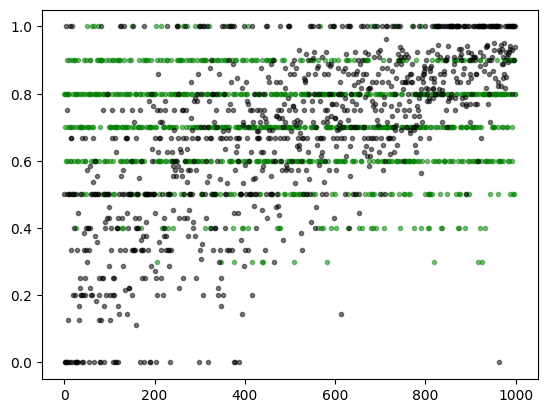

In [298]:
fig, ax = plt.subplots()

ax.plot(p_seed_liked_user, 'g.', alpha=0.5)
ax.plot(p_seed_user_liked, 'k.', alpha=0.5)

plt.show()

In [247]:
# rank users by percent swiped right

def zscore(a):
    return (a - a.mean()) / a.std()

current_score = zscore(p_seed_liked_user)


LEAK = 0.1

df["current_score"] = current_score * LEAK + df["current_score"] * (1. - LEAK)

# SCRATCH PAD BELOW

current stuff is being cleaned and commented as it moves up above here.  down below contains unfinished and also duplicated/forked stuff from above

In [268]:
def get_candidate_scores_for_swiper(
    i_swiper: int,
) -> List[float]:
    
    swiper = df.loc[i_swiper]
    
    def inner(row):
        swipee_score = row.current_score
        return model_infer_p_match(
            swiper_score = swiper.current_score,
            swipee_score = row.current_score
        )
    
    candidate_scores = df.apply(inner, axis=1)
    candidate_scores.loc[i_swiper] = 0.
    
    candidate_scores = candidate_scores / candidate_scores.sum()
    
    return candidate_scores

In [269]:
model_infer_p_match(
    swiper_score = df.loc[0].current_score,
    swipee_score = df.loc[503].current_score,
)

0.08576984447840807

In [274]:
p_match_for_swiper = get_candidate_scores_for_swiper(0)
print(p_match_for_swiper)

0      0.000000
1      0.001446
2      0.001446
3      0.001374
4      0.001446
         ...   
995    0.000148
996    0.000148
997    0.000148
998    0.000226
999    0.000148
Length: 1000, dtype: float64


In [276]:
N_ROUND_SWIPES = 10

def swipe_for_this_user(row):
    p_match_for_swiper = get_candidate_scores_for_swiper(row.name)
    
    return swipe_for_swipee(
        i_swipee = row.name,
        n_swiper = N_SEED_SWIPES,
        p_swiper = p_match_for_swiper,
    )

round_swipe_all_users = df.apply(swipe_for_this_user, axis=1)

In [278]:
round_swipe_all_users.sum(axis=1, skipna=True)

0      10.0
1      10.0
2      10.0
3      10.0
4      10.0
       ... 
995     0.0
996     2.0
997     3.0
998     2.0
999     3.0
Length: 1000, dtype: float64